# Finding best ANN Topology using pygenetic

In this example we are going to walk through the usage of GAEngine to find best ANN topology to solve a given classification problem.

## 1. Chromosome Representation

A chromosome to represent <b>different network topology parameters such as number of neurons in each layer, activation functions used and optimization algorithm</b> used to train the neural network is used

<img src="ANN-Chromosome.png" style="width:700px;">

For example,
For a 2 hidden layer neural network, a chromosome can be represented as [2,”sigmoid”,3,”sigmoid”, “relu”, “adam” ] which means first hidden layer has two neurons and sigmoid activation function, second layer has three neurons and sigmoid activation function while the output layer has “relu” activation. The neural network is trained using Adam optimization.

This can be easily done by defining a new ChromosomeFactory which takes the following as input
* `hiddenLayers` = the number of hidden layers in the ANN
* `neuronsPerLayer` = a list of all possible neurons per layer values the GA should include in it's search
* `activations` = a list of all possible activation functions the GA should include in it's search
* `optimizers` = a list of all possible ANN optimizer values the GA should include in it's search

It should output `(noOfNeurons,activation_function`) pairs for each hidden layer followed by `output_activation` and `optimizer`

In [1]:
from pygenetic.ChromosomeFactory import ChromosomeFactory
import random
class ANNTopologyChromosomeFactory(ChromosomeFactory):
    def __init__(self,hiddenLayers,neuronsPerLayer,activations,optimizers):
        self.neuronsPerLayer = neuronsPerLayer
        self.activations = activations
        self.optimizers = optimizers
        self.hiddenLayers = hiddenLayers

    def createChromosome(self):
        chromosome = []
        for i in range(self.hiddenLayers):
            chromosome.extend([random.choice(self.neuronsPerLayer), random.choice(self.activations)])
        chromosome.append(random.choice(self.activations))
        chromosome.append(random.choice(self.optimizers))
        return chromosome

Lets solve the ANN topology problem for 
* `hiddenLayers` = 2
* `neuronsPerLayer` = [2,5,10,12]
* `activations` = ['relu','sigmoid']
* `optimizers` = ['adam','sgd']

Let's create this factory

In [2]:
hidden_layers=2
neuronsPerLayer=[2,5,10,12]
activations=['relu','sigmoid']
optimizers=['adam','sgd']

factory = ANNTopologyChromosomeFactory(hiddenLayers=hidden_layers,neuronsPerLayer=neuronsPerLayer,activations=activations,
                                       optimizers=optimizers)

You can also check if the factory works as expected by calling createChromosome function and observing the chromosome produced by the factory

In [3]:
# Code to test if factory works as expected
for i in range(5):
    print('Chromosome created: ', factory.createChromosome())

Chromosome created:  [5, 'sigmoid', 2, 'sigmoid', 'relu', 'sgd']
Chromosome created:  [5, 'relu', 5, 'sigmoid', 'sigmoid', 'sgd']
Chromosome created:  [10, 'relu', 2, 'sigmoid', 'relu', 'sgd']
Chromosome created:  [5, 'relu', 5, 'sigmoid', 'relu', 'adam']
Chromosome created:  [10, 'relu', 10, 'sigmoid', 'sigmoid', 'sgd']


## 2. Fitness function 
Fitness for a given chromosome is the loss of the neural network of topology corresponding to that chromosome when trained for a given amount of time. So lesser the fitness, the better the chromosome. Hence our GA is a minimization problem.

In [4]:
from keras.models import Sequential
from keras.layers import Dense
def fitness(chromosome,X,Y,hidden_layers,input_dim,loss,metrics,epochs,batch_size):
    # create model
    model = Sequential()
    model.add(Dense(chromosome[0], input_dim= input_dim, activation=chromosome[1]))
    for i in range(hidden_layers-1):
        model.add(Dense(chromosome[i+2], activation=chromosome[i+3]))
    model.add(Dense(1, activation=chromosome[len(chromosome)-2]))
    # Compile model
    model.compile(loss=loss, optimizer=chromosome[len(chromosome)-1], metrics=[metrics])
    # Fit the model
    model.fit(X, Y, epochs=epochs, batch_size=batch_size,verbose=1)
    # evaluate the model
    scores = model.evaluate(X, Y)
    return scores[0]

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We need then create a `GAEngine` instance from the `pygenetic` package and set the following
* `factory` = the ANNTopologyChromosomeFactory factory instance we had intially created
* `population_size = 10` would be a good number for this problem ( for demonstration purposes)
* `cross_prob = 0.7`
* `mut_prob = 0.2`
* `fitness_type = 'min'` since this GA is a minimization problem

In [5]:
from pygenetic import GAEngine
ga = GAEngine.GAEngine(factory,population_size=20,fitness_type='min',cross_prob = 0.7,mut_prob = 0.2)

Lets now import our input data for the ANN and add the fitness function we had defined to this `GAEngine` instance

In [6]:
import numpy
# load pima indians dataset
dataset = numpy.loadtxt("input.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

Lets use `binary_crossentropy` and `accuracy` for loss and metrics respectively

In [7]:
ga.setFitnessHandler(fitness,X,Y,hidden_layers,len(X[0]),'binary_crossentropy','accuracy',30,10)

## 3. Determing other attributes of the GA

Many Standard Crossover, Mutation, Selection and Fitness functions are present in the `Utils` module of the `pygenetic` package.

In [8]:
from pygenetic import Utils

The use of popular crossover methods such as 1-point, 2-point crossover, etc can be used. Every child produced by such a crossover represents a new neural network topology which has the potential to possibly be better than others observed so far.

<img src="ANN-crossover.png" style="width:700px;"/>

This can be done using the addCrossoverHandler of the pygenetic module which takes as parameters
* crossover_function = the crossover function to be used
* weight = the weightage the crossover function needs to be given (mainly used when multiple crossovers are added)

In [9]:
ga.addCrossoverHandler(Utils.CrossoverHandlers.onePoint,1)

### Mutation

The use of mutations such as flipping an attribute to another of its possible values, swapping values between two same attributes of the chromosome. Each such child would represent a small change to a previous neural network which could potentially better than others observed so far.
<img src="ANN-mutation.png" style="width:700px">
We can define this function easily

In [10]:
import copy
def mutation(chromosome,neuronsPerLayer,activations,optimizers):
    r = random.randint(0,len(chromosome)-1)
    newchrom = copy.copy(chromosome)
    if r == len(chromosome) - 1:
        newchrom[r] = random.choice(optimizers)
    elif r%2 == 1 or r == len(chromosome)-2:
        newchrom[r] = random.choice(activations)
    elif r%2 == 0:
        newchrom[r] = random.choice(neuronsPerLayer)
    return newchrom

We can add the mutation function using the addMutationHandler of the pygenetic module which takes as parameters
mutation_function = the mutation function to be used
weight = the weightage the mutation function needs to be given (mainly used when multiple mutations are added)

In [11]:
ga.addMutationHandler(mutation,2,neuronsPerLayer,activations,optimizers)

## Selection
The selection function `best` chooses the best (1 - cross_prob) percent of the population. Hence, this function is one of the possible selection handlers which can be used in our genetic algorithm

In [12]:
ga.setSelectionHandler(Utils.SelectionHandlers.best)

## 4. Time to Evolve

This can be easily done using the `evolve` function of the GAEngine instance. It takes the `noOfIterations` as a parameter. Let's evolve it for 2 generations ( for demonstration purposes )

In [13]:
ga.evolve(2)

mutation_handlers_weights =  [1.0]
crossover_handlers_weights =  [1.0]
Epoch 1/30
768/768 [==============================] - 1s 805us/step - loss: 3.9776 - acc: 0.6510
Epoch 2/30
768/768 [==============================] - 0s 150us/step - loss: 2.9815 - acc: 0.6510
Epoch 3/30
768/768 [==============================] - 0s 252us/step - loss: 2.9265 - acc: 0.6510
Epoch 4/30
768/768 [==============================] - 0s 224us/step - loss: 2.5955 - acc: 0.6510
Epoch 5/30
768/768 [==============================] - 0s 151us/step - loss: 2.2763 - acc: 0.6510
Epoch 6/30
768/768 [==============================] - 0s 149us/step - loss: 2.1981 - acc: 0.6510
Epoch 7/30
768/768 [==============================] - 0s 144us/step - loss: 2.1357 - acc: 0.6510
Epoch 8/30
768/768 [==============================] - 0s 144us/step - loss: 2.0635 - acc: 0.6510
Epoch 9/30
768/768 [==============================] - 0s 182us/step - loss: 1.7269 - acc: 0.6510
Epoch 10/30
768/768 [==============================] - 0

768/768 [==============================] - 0s 130us/step - loss: 5.6245 - acc: 0.6510
Epoch 24/30
768/768 [==============================] - 0s 134us/step - loss: 5.6245 - acc: 0.6510
Epoch 25/30
768/768 [==============================] - 0s 129us/step - loss: 5.6245 - acc: 0.6510
Epoch 26/30
768/768 [==============================] - 0s 130us/step - loss: 5.6245 - acc: 0.6510
Epoch 27/30
768/768 [==============================] - 0s 134us/step - loss: 5.6245 - acc: 0.6510
Epoch 28/30
768/768 [==============================] - 0s 133us/step - loss: 5.6245 - acc: 0.6510
Epoch 29/30
768/768 [==============================] - 0s 130us/step - loss: 5.6245 - acc: 0.6510
Epoch 30/30
768/768 [==============================] - 0s 93us/step
Epoch 1/30
768/768 [==============================] - 0s 461us/step - loss: 10.3201 - acc: 0.2201
Epoch 2/30
768/768 [==============================] - 0s 109us/step - loss: 10.3201 - acc: 0.2214
Epoch 3/30
768/768 [==============================] - 0s 111us

Epoch 15/30
768/768 [==============================] - 0s 159us/step - loss: 0.6226 - acc: 0.6510
Epoch 16/30
768/768 [==============================] - 0s 153us/step - loss: 0.6206 - acc: 0.6510
Epoch 17/30
768/768 [==============================] - 0s 160us/step - loss: 0.6195 - acc: 0.6510
Epoch 18/30
768/768 [==============================] - 0s 171us/step - loss: 0.6169 - acc: 0.6510
Epoch 19/30
768/768 [==============================] - 0s 161us/step - loss: 0.6158 - acc: 0.6510
Epoch 20/30
768/768 [==============================] - 0s 175us/step - loss: 0.6139 - acc: 0.6510
Epoch 21/30
768/768 [==============================] - 0s 153us/step - loss: 0.6130 - acc: 0.6510
Epoch 22/30
768/768 [==============================] - 0s 196us/step - loss: 0.6106 - acc: 0.6510
Epoch 23/30
768/768 [==============================] - 0s 128us/step - loss: 0.6102 - acc: 0.6523
Epoch 24/30
768/768 [==============================] - 0s 132us/step - loss: 0.6084 - acc: 0.6628
Epoch 25/30
768/768 

768/768 [==============================] - 0s 138us/step - loss: 10.3796 - acc: 0.0026
Epoch 7/30
768/768 [==============================] - 0s 153us/step - loss: 10.3796 - acc: 0.0026
Epoch 8/30
768/768 [==============================] - 0s 155us/step - loss: 10.3796 - acc: 0.0026
Epoch 9/30
768/768 [==============================] - 0s 139us/step - loss: 10.3796 - acc: 0.0026
Epoch 10/30
768/768 [==============================] - 0s 141us/step - loss: 10.3796 - acc: 0.0026
Epoch 11/30
768/768 [==============================] - 0s 192us/step - loss: 10.3796 - acc: 0.0026
Epoch 12/30
768/768 [==============================] - 0s 251us/step - loss: 10.3796 - acc: 0.0026
Epoch 13/30
768/768 [==============================] - 0s 297us/step - loss: 10.3796 - acc: 0.0026
Epoch 14/30
768/768 [==============================] - 0s 142us/step - loss: 10.3796 - acc: 0.0026
Epoch 15/30
768/768 [==============================] - 0s 139us/step - loss: 10.3796 - acc: 0.0026
Epoch 16/30
768/768 [====

768/768 [==============================] - 0s 286us/step - loss: 0.6374 - acc: 0.6510
Epoch 29/30
768/768 [==============================] - 0s 263us/step - loss: 0.6361 - acc: 0.6510
Epoch 30/30
768/768 [==============================] - 0s 271us/step
Epoch 1/30
768/768 [==============================] - 1s 1ms/step - loss: 5.6245 - acc: 0.6510
Epoch 2/30
768/768 [==============================] - 0s 161us/step - loss: 5.6245 - acc: 0.6510
Epoch 3/30
768/768 [==============================] - 0s 144us/step - loss: 5.6245 - acc: 0.6510
Epoch 4/30
768/768 [==============================] - 0s 141us/step - loss: 5.6245 - acc: 0.6510
Epoch 5/30
768/768 [==============================] - 0s 264us/step - loss: 5.6245 - acc: 0.6510
Epoch 6/30
768/768 [==============================] - 0s 164us/step - loss: 5.6245 - acc: 0.6510
Epoch 7/30
768/768 [==============================] - 0s 298us/step - loss: 5.6245 - acc: 0.6510
Epoch 8/30
768/768 [==============================] - 0s 466us/step - 

768/768 [==============================] - 0s 316us/step - loss: 5.6245 - acc: 0.6510
Epoch 21/30
768/768 [==============================] - 0s 253us/step - loss: 5.6245 - acc: 0.6510
Epoch 22/30
768/768 [==============================] - 0s 166us/step - loss: 5.6245 - acc: 0.6510
Epoch 23/30
768/768 [==============================] - 0s 147us/step - loss: 5.6245 - acc: 0.6510
Epoch 24/30
768/768 [==============================] - 0s 148us/step - loss: 5.6245 - acc: 0.6510
Epoch 25/30
768/768 [==============================] - 0s 130us/step - loss: 5.6245 - acc: 0.6510
Epoch 26/30
768/768 [==============================] - 0s 128us/step - loss: 5.6245 - acc: 0.6510
Epoch 27/30
768/768 [==============================] - 0s 139us/step - loss: 5.6245 - acc: 0.6510
Epoch 28/30
768/768 [==============================] - 0s 132us/step - loss: 5.6245 - acc: 0.6510
Epoch 29/30
768/768 [==============================] - 0s 158us/step - loss: 5.6245 - acc: 0.6510
Epoch 30/30
768/768 [===========

768/768 [==============================] - 0s 138us/step - loss: 0.6250 - acc: 0.6510
Epoch 13/30
768/768 [==============================] - 0s 143us/step - loss: 0.6274 - acc: 0.6510
Epoch 14/30
768/768 [==============================] - 0s 136us/step - loss: 0.6192 - acc: 0.6510
Epoch 15/30
768/768 [==============================] - 0s 138us/step - loss: 0.6205 - acc: 0.6510
Epoch 16/30
768/768 [==============================] - 0s 143us/step - loss: 0.6210 - acc: 0.6510
Epoch 17/30
768/768 [==============================] - 0s 140us/step - loss: 0.6186 - acc: 0.6510
Epoch 18/30
768/768 [==============================] - 0s 135us/step - loss: 0.6196 - acc: 0.6510
Epoch 19/30
768/768 [==============================] - 0s 132us/step - loss: 0.6177 - acc: 0.6510
Epoch 20/30
768/768 [==============================] - 0s 134us/step - loss: 0.6143 - acc: 0.6510
Epoch 21/30
768/768 [==============================] - 0s 131us/step - loss: 0.6173 - acc: 0.6510
Epoch 22/30
768/768 [===========

768/768 [==============================] - 0s 145us/step - loss: 0.6364 - acc: 0.6497
Epoch 5/30
768/768 [==============================] - 0s 153us/step - loss: 0.6369 - acc: 0.6445
Epoch 6/30
768/768 [==============================] - 0s 145us/step - loss: 0.6373 - acc: 0.6458
Epoch 7/30
768/768 [==============================] - 0s 142us/step - loss: 0.6361 - acc: 0.6432
Epoch 8/30
768/768 [==============================] - 0s 144us/step - loss: 0.6355 - acc: 0.6497
Epoch 9/30
768/768 [==============================] - 0s 145us/step - loss: 0.6345 - acc: 0.6419
Epoch 10/30
768/768 [==============================] - 0s 144us/step - loss: 0.6370 - acc: 0.6458
Epoch 11/30
768/768 [==============================] - 0s 157us/step - loss: 0.6346 - acc: 0.6445
Epoch 12/30
768/768 [==============================] - 0s 136us/step - loss: 0.6335 - acc: 0.6471
Epoch 13/30
768/768 [==============================] - 0s 144us/step - loss: 0.6337 - acc: 0.6484
Epoch 14/30
768/768 [================

768/768 [==============================] - 0s 178us/step - loss: 5.6245 - acc: 0.6510
Epoch 14/30
768/768 [==============================] - 0s 181us/step - loss: 5.6245 - acc: 0.6510
Epoch 15/30
768/768 [==============================] - 0s 190us/step - loss: 5.6245 - acc: 0.6510
Epoch 16/30
768/768 [==============================] - 0s 195us/step - loss: 5.6245 - acc: 0.6510ETA: 0s - loss: 5.2384 - acc: 0.6750  
Epoch 17/30
768/768 [==============================] - 0s 173us/step - loss: 5.6245 - acc: 0.6510
Epoch 18/30
768/768 [==============================] - 0s 170us/step - loss: 5.6245 - acc: 0.6510
Epoch 19/30
768/768 [==============================] - 0s 172us/step - loss: 5.6245 - acc: 0.6510
Epoch 20/30
768/768 [==============================] - 0s 177us/step - loss: 5.6245 - acc: 0.6510
Epoch 21/30
768/768 [==============================] - 0s 168us/step - loss: 5.6245 - acc: 0.6510
Epoch 22/30
768/768 [==============================] - 0s 174us/step - loss: 5.6245 - acc: 0

768/768 [==============================] - 0s 166us/step - loss: 0.6388 - acc: 0.6510
Epoch 5/30
768/768 [==============================] - 0s 170us/step - loss: 0.6356 - acc: 0.6510
Epoch 6/30
768/768 [==============================] - 0s 176us/step - loss: 0.6329 - acc: 0.6510
Epoch 7/30
768/768 [==============================] - 0s 172us/step - loss: 0.6297 - acc: 0.6510
Epoch 8/30
768/768 [==============================] - 0s 167us/step - loss: 0.6268 - acc: 0.6510
Epoch 9/30
768/768 [==============================] - 0s 178us/step - loss: 0.6231 - acc: 0.6510
Epoch 10/30
768/768 [==============================] - 0s 174us/step - loss: 0.6211 - acc: 0.6510
Epoch 11/30
768/768 [==============================] - 0s 171us/step - loss: 0.6174 - acc: 0.6510
Epoch 12/30
768/768 [==============================] - 0s 170us/step - loss: 0.6146 - acc: 0.6510
Epoch 13/30
768/768 [==============================] - 0s 171us/step - loss: 0.6146 - acc: 0.6510
Epoch 14/30
768/768 [================

768/768 [==============================] - 0s 153us/step - loss: 0.6440 - acc: 0.6510
Epoch 27/30
768/768 [==============================] - 0s 158us/step - loss: 0.6439 - acc: 0.6510
Epoch 28/30
768/768 [==============================] - 0s 159us/step - loss: 0.6439 - acc: 0.6510
Epoch 29/30
768/768 [==============================] - 0s 152us/step - loss: 0.6439 - acc: 0.6510
Epoch 30/30
768/768 [==============================] - 0s 476us/step
Epoch 1/30
768/768 [==============================] - 1s 2ms/step - loss: 0.6223 - acc: 0.6484
Epoch 2/30
768/768 [==============================] - 0s 177us/step - loss: 0.5996 - acc: 0.6680
Epoch 3/30
768/768 [==============================] - 0s 179us/step - loss: 0.5920 - acc: 0.6641
Epoch 4/30
768/768 [==============================] - 0s 178us/step - loss: 0.5896 - acc: 0.6706
Epoch 5/30
768/768 [==============================] - 0s 177us/step - loss: 0.5861 - acc: 0.6693
Epoch 6/30
768/768 [==============================] - 0s 176us/step 

768/768 [==============================] - 0s 162us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 18/30
768/768 [==============================] - 0s 161us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 19/30
768/768 [==============================] - 0s 171us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 20/30
768/768 [==============================] - 0s 161us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 21/30
768/768 [==============================] - 0s 165us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 22/30
768/768 [==============================] - 0s 175us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 23/30
768/768 [==============================] - 0s 163us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 24/30
768/768 [==============================] - 0s 158us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 25/30
768/768 [==============================] - 0s 177us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 26/30
768/768 [==============================] - 0s 170us/step - loss: 10.3792 

768/768 [==============================] - 0s 196us/step - loss: 5.6245 - acc: 0.6510
Epoch 9/30
768/768 [==============================] - 0s 203us/step - loss: 5.6245 - acc: 0.6510
Epoch 10/30
768/768 [==============================] - 0s 193us/step - loss: 5.6245 - acc: 0.6510
Epoch 11/30
768/768 [==============================] - 0s 197us/step - loss: 5.6245 - acc: 0.6510
Epoch 12/30
768/768 [==============================] - 0s 196us/step - loss: 5.6245 - acc: 0.6510
Epoch 13/30
768/768 [==============================] - 0s 199us/step - loss: 5.6245 - acc: 0.6510
Epoch 14/30
768/768 [==============================] - 0s 199us/step - loss: 5.6245 - acc: 0.6510
Epoch 15/30
768/768 [==============================] - 0s 195us/step - loss: 5.6245 - acc: 0.6510
Epoch 16/30
768/768 [==============================] - 0s 195us/step - loss: 5.6245 - acc: 0.6510
Epoch 17/30
768/768 [==============================] - 0s 196us/step - loss: 5.6245 - acc: 0.6510
Epoch 18/30
768/768 [============

768/768 [==============================] - 0s 603us/step
Epoch 1/30
768/768 [==============================] - 1s 2ms/step - loss: 10.0212 - acc: 0.0495
Epoch 2/30
768/768 [==============================] - 0s 196us/step - loss: 9.9801 - acc: 0.0612
Epoch 3/30
768/768 [==============================] - 0s 193us/step - loss: 6.6635 - acc: 0.4987
Epoch 4/30
768/768 [==============================] - 0s 191us/step - loss: 5.6036 - acc: 0.6510
Epoch 5/30
768/768 [==============================] - 0s 191us/step - loss: 5.6036 - acc: 0.6510
Epoch 6/30
768/768 [==============================] - 0s 201us/step - loss: 5.6036 - acc: 0.6510
Epoch 7/30
768/768 [==============================] - 0s 191us/step - loss: 5.6036 - acc: 0.6510
Epoch 8/30
768/768 [==============================] - 0s 206us/step - loss: 5.6036 - acc: 0.6510
Epoch 9/30
768/768 [==============================] - 0s 193us/step - loss: 5.6036 - acc: 0.6510
Epoch 10/30
768/768 [==============================] - 0s 191us/step - 

768/768 [==============================] - 0s 173us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 22/30
768/768 [==============================] - 0s 171us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 23/30
768/768 [==============================] - 0s 172us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 24/30
768/768 [==============================] - 0s 171us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 25/30
768/768 [==============================] - 0s 171us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 26/30
768/768 [==============================] - 0s 173us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 27/30
768/768 [==============================] - 0s 170us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 28/30
768/768 [==============================] - 0s 171us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 29/30
768/768 [==============================] - 0s 172us/step - loss: 10.3792 - acc: 0.0000e+00
Epoch 30/30
768/768 [==============================] - 1s 674us/step
Epoch 1/30
768/7

We can get the best member by using the `best_fitness` attribute of the `GAEngine`. 
It returns a tuple having
* chromsome having best fitness
* best fitness value

In [14]:
best = ga.best_fitness
print(best)

([12, 'sigmoid', 10, 'relu', 'relu', 'adam'], 0.5369872798522314)


## 5. Plotting the Statistics

- The functionality for plotting the best, worst, average fitness values across iterations is present in `plot_statistics` function of statistics.py module. The function takes a list of attributes to be plotted.
- These attributes can be `best-fitness`,`worst-fitness`,`avg-fitness`, `'diversity`, `mutation_rate`
- The diversity and mutation rate values over iterations can also be visualized 

best-fitness [0.5518418923020363, 0.5369872798522314]
worst-fitness [10.379614929358164, 10.37915732463201]
avg-fitness [2.8955850816642243, 3.0842435689022145]


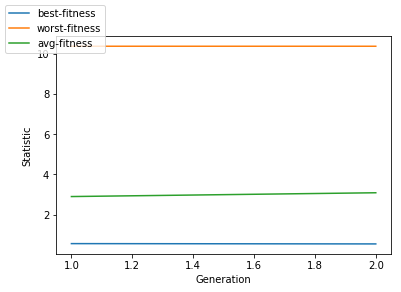

diversity [0.727421529803464, 0.7401248065976704]


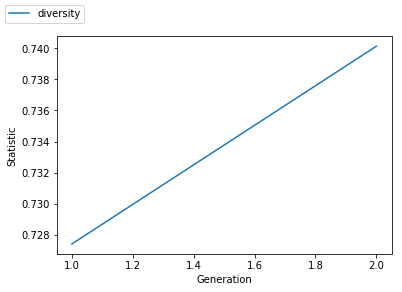

mutation_rate [0.17254988543134508, 0.1681879877419189]


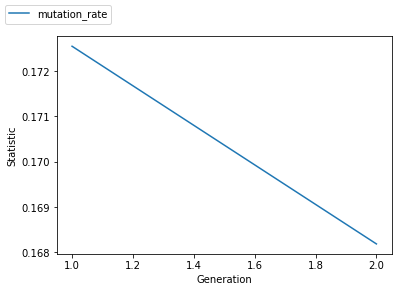

In [15]:
import matplotlib.pyplot as plt
fig = ga.statistics.plot_statistics(['best-fitness','worst-fitness','avg-fitness'])
plt.show()
fig = ga.statistics.plot_statistics(['diversity'])
plt.show()
fig = ga.statistics.plot_statistics(['mutation_rate'])
plt.show()